In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression #log regression

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score, fbeta_score
from sklearn.metrics import log_loss
from sklearn import metrics

from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTENC

from IPython.display import Image  
from six import StringIO  
import graphviz
import pydot 

In [2]:
ccdata = pd.read_csv('BankChurners.csv')
ccdata.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [3]:
#run once
ccdata.drop("CLIENTNUM",axis=1,inplace=True)
ccdata.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',axis=1,inplace=True)
ccdata.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',axis=1,inplace=True)
#run once
ccdata['Gender'].replace({'M':1,'F':0},inplace=True)
ccdata["Attrition_Flag"].replace({'Existing Customer':0,'Attrited Customer':1},inplace=True)
#run once
#drop_first = True to avoid structural multicollinearity
ccdata2 = pd.get_dummies(data=ccdata,columns=['Education_Level','Marital_Status',"Income_Category",'Card_Category'],drop_first=True)
ccdata2.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Education_Level_Unknown',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Unknown', 'Income_Category_$40K - $60K',
       'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K',
       'Income_Category_Less than $40K', 'Income_Category_Unknown',
       'Card_Category_Gold', 'Card_Category_Platinum', 'Card_Category_Silver'],
      dtype='object')

In [4]:
features = list(ccdata.columns[1:])
features

['Customer_Age',
 'Gender',
 'Dependent_count',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

def vif_func(dataset,dependent_var,threshold,vif):
    independent_vars = dataset.drop(dependent_var, axis=1)
    vif_data = pd.DataFrame()
    vif_data['features'] = independent_vars.columns

    vif_data["VIF"] = [variance_inflation_factor(independent_vars.values, i) 
                        for i in range(len(independent_vars.columns))] 
    
    vd = vif_data.sort_values(by='VIF',ascending=False)
    print(vd)

In [6]:
vif_func(ccdata2,'Attrition_Flag',10,variance_inflation_factor)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                          features        VIF
9                  Avg_Open_To_Buy        inf
7                     Credit_Limit        inf
8              Total_Revolving_Bal        inf
0                     Customer_Age  81.150133
3                   Months_on_book  56.495249
12                  Total_Trans_Ct  24.593854
10            Total_Amt_Chng_Q4_Q1  14.602178
13             Total_Ct_Chng_Q4_Q1  11.942046
27  Income_Category_Less than $40K   9.041355
11                 Total_Trans_Amt   8.779247
4         Total_Relationship_Count   7.762263
21          Marital_Status_Married   6.820507
5           Months_Inactive_12_mon   6.229469
14           Avg_Utilization_Ratio   5.966408
22           Marital_Status_Single   5.895901
1                           Gender   5.828726
6            Contacts_Count_12_mon   5.815430
2                  Dependent_count   4.178267
24     Income_Category_$40K - $60K   4.030773
16        Education_Level_Graduate   3.927042
28         Income_Category_Unknown

In [7]:
ccdata2.drop(['Avg_Open_To_Buy','Credit_Limit','Total_Revolving_Bal','Customer_Age'],axis=1,inplace=True)

In [8]:
vif_func(ccdata2,'Attrition_Flag',10,variance_inflation_factor)

                          features        VIF
8                   Total_Trans_Ct  24.322031
2                   Months_on_book  17.310352
6             Total_Amt_Chng_Q4_Q1  14.488463
9              Total_Ct_Chng_Q4_Q1  11.859837
7                  Total_Trans_Amt   8.660171
23  Income_Category_Less than $40K   8.106153
3         Total_Relationship_Count   7.688292
17          Marital_Status_Married   6.664835
4           Months_Inactive_12_mon   6.189771
18           Marital_Status_Single   5.780165
5            Contacts_Count_12_mon   5.758187
0                           Gender   5.673033
1                  Dependent_count   4.132927
12        Education_Level_Graduate   3.879802
20     Income_Category_$40K - $60K   3.590206
24         Income_Category_Unknown   3.221451
22    Income_Category_$80K - $120K   2.876901
13     Education_Level_High School   2.849573
21     Income_Category_$60K - $80K   2.721467
10           Avg_Utilization_Ratio   2.395049
16         Education_Level_Unknown

In [9]:
ccdata2.drop(['Total_Trans_Ct','Months_on_book'],axis=1,inplace=True)

In [10]:
vif_func(ccdata2,'Attrition_Flag',10,variance_inflation_factor)

                          features        VIF
5             Total_Amt_Chng_Q4_Q1  14.398131
7              Total_Ct_Chng_Q4_Q1  11.584994
21  Income_Category_Less than $40K   7.536344
2         Total_Relationship_Count   7.402028
15          Marital_Status_Married   6.374518
3           Months_Inactive_12_mon   5.952799
4            Contacts_Count_12_mon   5.692643
0                           Gender   5.518773
16           Marital_Status_Single   5.502146
1                  Dependent_count   4.049303
10        Education_Level_Graduate   3.792784
18     Income_Category_$40K - $60K   3.392438
6                  Total_Trans_Amt   3.077873
22         Income_Category_Unknown   3.024343
20    Income_Category_$80K - $120K   2.808653
11     Education_Level_High School   2.792867
19     Income_Category_$60K - $80K   2.665325
8            Avg_Utilization_Ratio   2.373548
14         Education_Level_Unknown   2.348603
13      Education_Level_Uneducated   2.323410
17          Marital_Status_Unknown

In [11]:
ccdata2.drop(['Total_Amt_Chng_Q4_Q1'],axis=1,inplace=True)

In [12]:
vif_func(ccdata2,'Attrition_Flag',10,variance_inflation_factor)

                          features       VIF
6              Total_Ct_Chng_Q4_Q1  9.313788
20  Income_Category_Less than $40K  7.342106
2         Total_Relationship_Count  7.287914
14          Marital_Status_Married  6.285718
3           Months_Inactive_12_mon  5.935362
4            Contacts_Count_12_mon  5.653085
15           Marital_Status_Single  5.461171
0                           Gender  5.425596
1                  Dependent_count  4.046025
9         Education_Level_Graduate  3.776571
17     Income_Category_$40K - $60K  3.322008
5                  Total_Trans_Amt  3.055020
21         Income_Category_Unknown  2.948997
19    Income_Category_$80K - $120K  2.783117
10     Education_Level_High School  2.780470
18     Income_Category_$60K - $80K  2.641119
7            Avg_Utilization_Ratio  2.371177
13         Education_Level_Unknown  2.338661
12      Education_Level_Uneducated  2.315148
16          Marital_Status_Unknown  1.861229
11   Education_Level_Post-Graduate  1.460931
8        E

In [13]:
ccdata2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Attrition_Flag                  10127 non-null  int64  
 1   Gender                          10127 non-null  int64  
 2   Dependent_count                 10127 non-null  int64  
 3   Total_Relationship_Count        10127 non-null  int64  
 4   Months_Inactive_12_mon          10127 non-null  int64  
 5   Contacts_Count_12_mon           10127 non-null  int64  
 6   Total_Trans_Amt                 10127 non-null  int64  
 7   Total_Ct_Chng_Q4_Q1             10127 non-null  float64
 8   Avg_Utilization_Ratio           10127 non-null  float64
 9   Education_Level_Doctorate       10127 non-null  uint8  
 10  Education_Level_Graduate        10127 non-null  uint8  
 11  Education_Level_High School     10127 non-null  uint8  
 12  Education_Level_Post-Graduate   

## modelling

In [14]:
X = ccdata2.drop("Attrition_Flag",axis=1)
y = ccdata2['Attrition_Flag']

In [15]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

In [16]:
from logitmodule import stats_logit

logitmodule.py is being imported into another module


In [17]:
lgt1 = stats_logit(X_train,X_test,y_train,y_test)

Optimization terminated successfully.
         Current function value: 0.314552
         Iterations 7


In [18]:
lgt1.classification_report()
lgt1.confusion_matrix()
lgt1.KPI_summary()
lgt1.summary()

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2551
           1       0.76      0.36      0.49       488

    accuracy                           0.88      3039
   macro avg       0.82      0.67      0.71      3039
weighted avg       0.87      0.88      0.86      3039

Confusion Matrix
 [[2495   56]
 [ 312  176]]
accuracy score: 0.8789075353734781
recall score: 0.36065573770491804
f2 score: 0.40293040293040294
                           Logit Regression Results                           
Dep. Variable:         Attrition_Flag   No. Observations:                 7088
Model:                          Logit   Df Residuals:                     7063
Method:                           MLE   Df Model:                           24
Date:                Sun, 04 Jul 2021   Pseudo R-squ.:                  0.2864
Time:                        20:18:58   Log-Likelihood:                -2229.5
converged:                       True   LL-Null:       

In [19]:
## Initial model ##
sm_model = sm.Logit(y_train,X_train).fit()
sm_model.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.314552
         Iterations 7


7403    0.005654
2005    0.877189
8270    0.070955
646     0.305681
1690    0.371700
          ...   
5950    0.013454
3434    0.147159
9023    0.023893
6599    0.010977
8523    0.254232
Length: 3039, dtype: float64

In [20]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         Attrition_Flag   No. Observations:                 7088
Model:                          Logit   Df Residuals:                     7063
Method:                           MLE   Df Model:                           24
Date:                Sun, 04 Jul 2021   Pseudo R-squ.:                  0.2864
Time:                        20:19:00   Log-Likelihood:                -2229.5
converged:                       True   LL-Null:                       -3124.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Gender                            -0.2144      0.132     -1.621      0.105      -0.474       0.045
Dependent_count                    0.0812      0.029      2.808      0.005       0.025       0.138
Total_Relationship_Count          -0.4206      0.027    -15.693      0.000      -0.473      -0.368
Months_Inactive_12_mon             0.4492      0.036     12.307      0.000       0.378       0.521
Contacts_Count_12_mon              0.5117      0.036     14.225      0.000       0.441       0.582
Total_Trans_Amt                   -0.0002   1.93e-05    -12.295      0.000      -0.000      -0.000
Total_Ct_Chng_Q4_Q1               -3.4302      0.206    -16.644      0.000      -3.834      -3.026
Avg_Utilization_Ratio             -2.3788      0.167    -14.214      0.000      -2.707      -2.051
Education_Level_Doctorate          0.5313      0.210      2.535      0.011       0.121       0.942
Education_Level_Graduate           0.2292      0.139      1.643      0.100      -0.044       0.503
Education_Level_High School        0.2828      0.148      1.905      0.057      -0.008       0.574
Education_Level_Post-Graduate      0.5983      0.203      2.949      0.003       0.201       0.996
Education_Level_Uneducated         0.3246      0.158      2.060      0.039       0.016       0.634
Education_Level_Unknown            0.3743      0.156      2.405      0.016       0.069       0.679
Marital_Status_Married             0.1900      0.150      1.270      0.204      -0.103       0.483
Marital_Status_Single              0.3589      0.151      2.372      0.018       0.062       0.656
Marital_Status_Unknown             0.5115      0.195      2.624      0.009       0.129       0.894
Income_Category_$40K - $60K        0.3790      0.170      2.231      0.026       0.046       0.712
Income_Category_$60K - $80K        0.1986      0.172      1.153      0.249      -0.139       0.536
Income_Category_$80K - $120K       0.2185      0.167      1.307      0.191      -0.109       0.546
Income_Category_Less than $40K     0.7275      0.178      4.080      0.000       0.378       1.077
Income_Category_Unknown            0.1663      0.202      0.825      0.409      -0.229       0.561
Card_Category_Gold                 0.1393      0.368      0.379      0.705      -0.582       0.860
Card_Category_Platinum             1.0046      0.693      1.450      0.147      -0.353       2.363
Card_Category_Silver              -0.0517      0.176     -0.293      0.769      -0.397       0.294
==================================================================================================
"""

In [21]:
sk_model = LogisticRegression(fit_intercept = False, C = 1e9)
sk_model.fit(X_train,y_train)
sk_model.coef_

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[-6.00305340e-01,  1.23256005e-01, -4.15951531e-01,
         4.88822364e-01,  5.86253230e-01, -2.81606595e-04,
        -1.93368160e+00, -1.69269479e+00,  1.15335111e-01,
        -2.51643331e-01, -1.28085687e-01,  1.63471329e-01,
        -9.17796247e-03,  5.21724989e-03, -5.87558502e-01,
         1.15351412e-01,  1.89891531e-01, -1.75795158e-01,
        -2.19809197e-01, -1.12959793e-01,  3.06510789e-01,
        -1.46792938e-01,  5.79197206e-02,  4.70077355e-02,
         1.21549361e-01]])

In [22]:
X_train.max()

Gender                                1.000
Dependent_count                       5.000
Total_Relationship_Count              6.000
Months_Inactive_12_mon                6.000
Contacts_Count_12_mon                 6.000
Total_Trans_Amt                   18484.000
Total_Ct_Chng_Q4_Q1                   3.714
Avg_Utilization_Ratio                 0.995
Education_Level_Doctorate             1.000
Education_Level_Graduate              1.000
Education_Level_High School           1.000
Education_Level_Post-Graduate         1.000
Education_Level_Uneducated            1.000
Education_Level_Unknown               1.000
Marital_Status_Married                1.000
Marital_Status_Single                 1.000
Marital_Status_Unknown                1.000
Income_Category_$40K - $60K           1.000
Income_Category_$60K - $80K           1.000
Income_Category_$80K - $120K          1.000
Income_Category_Less than $40K        1.000
Income_Category_Unknown               1.000
Card_Category_Gold              

In [23]:
cols_to_scale = ['Dependent_count','Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon','Total_Trans_Amt','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.fit_transform(X_test[cols_to_scale]) 

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [24]:
X_train.max()

Gender                            1.0
Dependent_count                   1.0
Total_Relationship_Count          1.0
Months_Inactive_12_mon            1.0
Contacts_Count_12_mon             1.0
Total_Trans_Amt                   1.0
Total_Ct_Chng_Q4_Q1               1.0
Avg_Utilization_Ratio             1.0
Education_Level_Doctorate         1.0
Education_Level_Graduate          1.0
Education_Level_High School       1.0
Education_Level_Post-Graduate     1.0
Education_Level_Uneducated        1.0
Education_Level_Unknown           1.0
Marital_Status_Married            1.0
Marital_Status_Single             1.0
Marital_Status_Unknown            1.0
Income_Category_$40K - $60K       1.0
Income_Category_$60K - $80K       1.0
Income_Category_$80K - $120K      1.0
Income_Category_Less than $40K    1.0
Income_Category_Unknown           1.0
Card_Category_Gold                1.0
Card_Category_Platinum            1.0
Card_Category_Silver              1.0
dtype: float64

## hyperparameter optimization

In [48]:
logit_r = LogisticRegression()

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
parameter_grid = [
    {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': np.logspace(-4,4,20),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter':[100,1000,1750,2500]
    }
]

In [51]:
clf = GridSearchCV(logit_r, param_grid = parameter_grid, cv = 5, verbose=True, n_jobs = -1)

In [52]:
best_clf = clf.fit(X_train,y_train)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.83930591 ...        nan 0.88163087 0.88163087]
  category=UserWarning


In [53]:
rawresults = pd.DataFrame(clf.cv_results_)
#rawresults

In [54]:
best_clf.best_estimator_

LogisticRegression(C=4.281332398719396, solver='newton-cg')

In [38]:
best_clf.best_score_

0.8826183766932463

## testing

In [25]:
from logitmodule import sk_logit, sk_logit_balanced

In [26]:
logit1 = sk_logit(X_train,X_test,y_train,y_test)

In [27]:
logit1.model

LogisticRegression(C=4.281332398719396, solver='newton-cg')

In [28]:
logit1.KPI_summary()

accuracy score =  88.12 %
recall =  29.71 %
precision =  88.96 %
f2_score =  34.28 %
training accuracy =  88.32 %
testing accuracy =  88.12 %


Confusion Matrix
 [[2533   18]
 [ 343  145]]


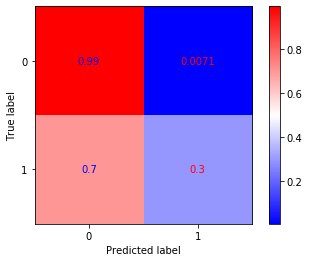

In [29]:
logit1.confusion_matrix()

In [30]:
#SMOTENC uses k-nearest neighbour algo to create synthetic samples 
#"Note - SMOTENC takes into consideration categorical and continuous variables"
from imblearn.over_sampling import SMOTE

#X= ccdata2.drop('Attrition_Flag',axis='columns')
#y= ccdata2['Attrition_Flag']
smote = SMOTE(sampling_strategy='minority') 
#samplingstrat specifies whether to use the minority or majority value for under/over-sampling
X_sm, y_sm = smote.fit_resample(X_train,y_train)

y_sm.value_counts()
#generate train test split first then do resampling only on training set

1    5949
0    5949
Name: Attrition_Flag, dtype: int64

In [31]:
logit2 = sk_logit(X_sm,X_test,y_sm,y_test)

In [32]:
logit2.KPI_summary()

accuracy score =  83.48 %
recall =  62.3 %
precision =  48.87 %
f2_score =  59.05 %
training accuracy =  78.96 %
testing accuracy =  83.48 %


In [33]:
##### With Pipeline Step resampling #####
over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)
X_train3, y_train3 = pipeline.fit_resample(X_train,y_train)
y_train3.value_counts()

0    3965
1    2379
Name: Attrition_Flag, dtype: int64

In [34]:
logit3 = sk_logit(X_train3,X_test,y_train3,y_test)
logit3.KPI_summary()

accuracy score =  86.67 %
recall =  54.71 %
precision =  59.2 %
f2_score =  55.56 %
training accuracy =  80.56 %
testing accuracy =  86.67 %


## post-feature selection

In [35]:
## remove p-value greater than 0.05 ##
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         Attrition_Flag   No. Observations:                 7088
Model:                          Logit   Df Residuals:                     7063
Method:                           MLE   Df Model:                           24
Date:                Sun, 04 Jul 2021   Pseudo R-squ.:                  0.2864
Time:                        20:19:27   Log-Likelihood:                -2229.5
converged:                       True   LL-Null:                       -3124.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Gender                            -0.2144      0.132     -1.621      0.105      -0.474       0.045
Dependent_count                    0.0812      0.029      2.808      0.005       0.025       0.138
Total_Relationship_Count          -0.4206      0.027    -15.693      0.000      -0.473      -0.368
Months_Inactive_12_mon             0.4492      0.036     12.307      0.000       0.378       0.521
Contacts_Count_12_mon              0.5117      0.036     14.225      0.000       0.441       0.582
Total_Trans_Amt                   -0.0002   1.93e-05    -12.295      0.000      -0.000      -0.000
Total_Ct_Chng_Q4_Q1               -3.4302      0.206    -16.644      0.000      -3.834      -3.026
Avg_Utilization_Ratio             -2.3788      0.167    -14.214      0.000      -2.707      -2.051
Education_Level_Doctorate          0.5313      0.210      2.535      0.011       0.121       0.942
Education_Level_Graduate           0.2292      0.139      1.643      0.100      -0.044       0.503
Education_Level_High School        0.2828      0.148      1.905      0.057      -0.008       0.574
Education_Level_Post-Graduate      0.5983      0.203      2.949      0.003       0.201       0.996
Education_Level_Uneducated         0.3246      0.158      2.060      0.039       0.016       0.634
Education_Level_Unknown            0.3743      0.156      2.405      0.016       0.069       0.679
Marital_Status_Married             0.1900      0.150      1.270      0.204      -0.103       0.483
Marital_Status_Single              0.3589      0.151      2.372      0.018       0.062       0.656
Marital_Status_Unknown             0.5115      0.195      2.624      0.009       0.129       0.894
Income_Category_$40K - $60K        0.3790      0.170      2.231      0.026       0.046       0.712
Income_Category_$60K - $80K        0.1986      0.172      1.153      0.249      -0.139       0.536
Income_Category_$80K - $120K       0.2185      0.167      1.307      0.191      -0.109       0.546
Income_Category_Less than $40K     0.7275      0.178      4.080      0.000       0.378       1.077
Income_Category_Unknown            0.1663      0.202      0.825      0.409      -0.229       0.561
Card_Category_Gold                 0.1393      0.368      0.379      0.705      -0.582       0.860
Card_Category_Platinum             1.0046      0.693      1.450      0.147      -0.353       2.363
Card_Category_Silver              -0.0517      0.176     -0.293      0.769      -0.397       0.294
==================================================================================================
"""

In [36]:
X_train2 = X_train.drop(['Gender',
                         'Education_Level_Graduate',
                         'Education_Level_High School',
                         'Marital_Status_Married',
                         'Income_Category_$60K - $80K',
                         'Income_Category_$80K - $120K',
                         'Card_Category_Gold',
                         'Card_Category_Platinum',
                         'Card_Category_Silver'],axis=1)

X_test2 = X_test.drop(['Gender',
                       'Education_Level_Graduate',
                       'Education_Level_High School',
                       'Marital_Status_Married',
                       'Income_Category_$60K - $80K',
                       'Income_Category_$80K - $120K',
                       'Card_Category_Gold',
                       'Card_Category_Platinum',
                       'Card_Category_Silver'],axis=1)

In [37]:
from sklearn.model_selection import GridSearchCV
r_logit = LogisticRegression()
parameter_grid = [
    {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': np.logspace(-4,4,20),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter':[100,1000,1750,2500]
    }
]
clf1 = GridSearchCV(r_logit, param_grid = parameter_grid, cv = 5, verbose=True, n_jobs = -1)
best_clf1 = clf1.fit(X_train2,y_train)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.83930591 ...        nan 0.88134888 0.88134888]
  category=UserWarning
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


In [38]:
best_clf1.best_estimator_

LogisticRegression(C=0.0001, penalty='none', solver='newton-cg')

In [39]:
logit4 = sk_logit(X_train2,X_test2,y_train,y_test)
logit4.KPI_summary()

accuracy score =  88.06 %
recall =  29.71 %
precision =  87.88 %
f2_score =  34.25 %
training accuracy =  88.23 %
testing accuracy =  88.06 %


In [40]:
#SMOTE uses k-nearest neighbour algo to create synthetic samples 
#"Note - SMOTENC takes into consideration categorical and continuous variables"
from imblearn.over_sampling import SMOTE

#X= ccdata2.drop('Attrition_Flag',axis='columns')
#y= ccdata2['Attrition_Flag']
smote = SMOTE(sampling_strategy='minority') 
#samplingstrat specifies whether to use the minority or majority value for under/over-sampling
X_sm2, y_sm2 = smote.fit_resample(X_train2,y_train)

y_sm2.value_counts()
#generate train test split first then do resampling only on training set

1    5949
0    5949
Name: Attrition_Flag, dtype: int64

In [41]:
logit5 = sk_logit(X_sm2,X_test2,y_sm2,y_test)

In [42]:
logit5.KPI_summary()

accuracy score =  83.15 %
recall =  62.7 %
precision =  48.11 %
f2_score =  59.12 %
training accuracy =  78.01 %
testing accuracy =  83.15 %


In [43]:
##### With Pipeline Step resampling #####
over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)
X_train4, y_train4 = pipeline.fit_resample(X_train2,y_train)
y_train4.value_counts()

0    3965
1    2379
Name: Attrition_Flag, dtype: int64

In [44]:
logit6 = sk_logit(X_train4, X_test2,y_train4,y_test)

In [45]:
logit6.KPI_summary()

accuracy score =  86.05 %
recall =  52.87 %
precision =  57.08 %
f2_score =  53.66 %
training accuracy =  78.86 %
testing accuracy =  86.05 %


## class weight rebalanced

In [55]:
logit7 = sk_logit_balanced(X_train,X_test,y_train,y_test)

In [56]:
logit7.model

LogisticRegression(C=4.281332398719396, class_weight='balanced',
                   solver='newton-cg')

In [57]:
logit7.KPI_summary()

accuracy score =  82.13 %
recall =  65.78 %
precision =  46.05 %
f2_score =  60.59 %
training accuracy =  76.58 %
testing accuracy =  82.13 %


In [60]:
logit8 = sk_logit_balanced(X_sm,X_test,y_sm,y_test)

In [61]:
logit8.KPI_summary()

accuracy score =  83.48 %
recall =  62.3 %
precision =  48.87 %
f2_score =  59.05 %
training accuracy =  78.96 %
testing accuracy =  83.48 %


In [62]:
logit9 = sk_logit_balanced(X_train3,X_test,y_train3,y_test)
logit9.KPI_summary()

accuracy score =  83.12 %
recall =  63.32 %
precision =  48.06 %
f2_score =  59.54 %
training accuracy =  78.64 %
testing accuracy =  83.12 %


In [63]:
logit8 = sk_logit_balanced(X_sm,X_test,y_sm,y_test)
logit9 = sk_logit_balanced(X_train3,X_test,y_train3,y_test)
logit10 = sk_logit_balanced(X_train2,X_test2,y_train,y_test)
logit11 = sk_logit_balanced(X_sm2,X_test2,y_sm2,y_test)
logit12 = sk_logit_balanced(X_train4, X_test2,y_train4,y_test)

In [64]:
logit1.model

LogisticRegression(C=4.281332398719396, solver='newton-cg')

In [65]:
ls = [logit1,logit2,logit3,logit4,logit5,logit6]
[print('logit{} f2 score: '.format(i+1), x.f2_score,'\n') for i,x in enumerate(ls)]

logit1 f2 score:  0.34278959810874704 

logit2 f2 score:  0.5905205905205905 

logit3 f2 score:  0.5555555555555555 

logit4 f2 score:  0.3424657534246575 

logit5 f2 score:  0.5911901081916537 

logit6 f2 score:  0.5366056572379367 



[None, None, None, None, None, None]

In [66]:
ls1 = [logit7,logit8,logit9,logit10,logit11,logit12]
[print('logit{} f2 score: '.format(i+7), x.f2_score,'\n') for i,x in enumerate(ls1)]

logit7 f2 score:  0.6058890147225369 

logit8 f2 score:  0.5905205905205905 

logit9 f2 score:  0.5953757225433526 

logit10 f2 score:  0.6011342155009453 

logit11 f2 score:  0.5911901081916537 

logit12 f2 score:  0.5951926745516979 



[None, None, None, None, None, None]

In [286]:
logit7.model

LogisticRegression(C=0.615848211066026, class_weight='balanced', max_iter=2500,
                   penalty='l1', solver='liblinear')